Read 1 wsi images: 


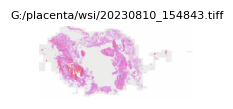

In [1]:
##########################################################################################################
# Author: Mihaly Sulyok & Peter Karacsonyi                                                               #
# Last updated: 2023 Dec 10                                                                              #
# This workbook does wsi preprocessing with Pathml version 2.1.1                                         #
# Input: wsi image files, tested with OpenSlide .tif                                                     #
# Transformations: MedianBlur, BinaryThreshold, Tiling, MorphOpen, MorphClose, ForegroundDetection       #
# Read more on transformations: https://pathml.readthedocs.io/en/latest/examples/link_gallery.html       #
# Output: h5path files (https://pathml.readthedocs.io/en/latest/h5path.html)                             #
##########################################################################################################

# local imports
import os
if os.name == 'nt':
    import helpers.openslideimport #on windows, openslide needs to be installed manually, check local openslideimport.py

# global imports
import time
from pathlib import Path
import matplotlib.pyplot as plt

# pathml imports
from pathml import types
from pathml.core import SlideData, SlideDataset
from pathml.preprocessing import Pipeline, TissueDetectionHE

#########
# usage #
#########

#####################
# configure folders #
#####################

# set working directory
base_dir = Path("G:\\placenta") # "/mnt/g/xyz/" for linux
# wsi folder
wsi_subfolder = "wsi"
# place geojsons into this folder inside base with same name as the image (echino23.tiff / echino38.gejson)
annotations_subfolder = "none"
# output h5path files to (will be created)
h5path_subfolder = "h5"
# filenames having this substring with endpoint, possibly having annotation
endpoint_filename = "endpoint"

#######################################
# configure transformation parameters #
#######################################

pipeline = Pipeline([
    # values are the best found for placenta wsis
    TissueDetectionHE(
        mask_name = "tissue", 
        min_region_size=500,
        outer_contours_only=True
    )
])

# relative directory generation (don't modify)
data_dir = base_dir / Path(wsi_subfolder)                       # input
h5_dir = base_dir / Path(h5path_subfolder)                      # output
h5_dir.mkdir(0o644, parents=True, exist_ok=True)                # create if does not exist

# read wsi files
wsi_paths = list(data_dir.glob("*.tif*"))
wsi_list = []

for wsi in wsi_paths:
        wsi_list.append(
            SlideData(
                wsi.as_posix(), 
                name = wsi.as_posix(), 
                backend = "openslide", 
                slide_type = types.HE,
                # labels = label
            )
        )

slide_dataset = SlideDataset(wsi_list)

# Draw the images
print(f"Read {len(slide_dataset)} wsi images: ")
for slide in slide_dataset:
    _, axs = plt.subplots(figsize=(2, 2))
    slide.plot(ax=axs)
    axs.set_title(label=slide.name, fontsize=8)

In [2]:
# run preprocessing pipeline
start_time = time.time()
slide_dataset.run(
    pipeline,
    distributed=True, # OpenSlide DLL error can be fixed by importing into core.py
    tile_size=500, # https://www.sciencedirect.com/science/article/pii/S2352914822000053
    overwrite_existing_tiles=True,
    write_dir=str(h5_dir), # The write_dir is buggy: places h5path files to where images were, so I move them to another dir...
    level = 0
)

### Additional parameters to pass to slide.run: 
# from https://pathml.readthedocs.io/en/latest/api_core_reference.html#pathml.core.SlideData.run

# pipeline (pathml.preprocessing.pipeline.Pipeline) – Preprocessing pipeline.

# distributed (bool) – Whether to distribute model using client. Defaults to True.

# client – dask.distributed client

# tile_size (int, optional) – Size of each tile. Defaults to 256px

# tile_stride (int, optional) – Stride between tiles. If None, uses tile_stride = tile_size for non-overlapping tiles. Defaults to None.

# level (int, optional) – Level to extract tiles from. Defaults to None.

# tile_pad (bool) – How to handle chunks on the edges. If True, these edge chunks will be zero-padded symmetrically and yielded with the other chunks. If False, incomplete edge chunks will be ignored. Defaults to False.

# overwrite_existing_tiles (bool) – Whether to overwrite existing tiles. If False, running a pipeline will fail if tiles is not None. Defaults to False.

# write_dir (str) – Path to directory to write the processed slide to. The processed SlideData object will be written to the directory immediately after the pipeline has completed running. The filepath will default to “<write_dir>/<slide.name>.h5path. Defaults to None.

# **kwargs – Other arguments passed through to generate_tiles() method of the backend.

###

# counting extracted tiles:
total_tiles = 0
for slide in slide_dataset.slides:
    total_tiles = total_tiles + len(slide.tiles.keys)

print(f"Total number of tiles extracted: {total_tiles}")

# move h5path files from wsi dir to a new dir
h5_paths = list(data_dir.glob("*.h5path"))
print(f"Writing {len(h5_paths)} h5path images to {str(h5_dir)}: ")
for h5file in h5_paths:
    h5file.replace(h5_dir/h5file.name)
    print(h5_dir/h5file.name)

time_elapsed = time.time() - start_time
print('Preprocessing completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Total number of tiles extracted: 684
Writing 1 h5path images to G:\placenta\h5: 
G:\placenta\h5\20230810_154843.tiff.h5path
Preprocessing completed in 0m 28s
